In [116]:
import os, sys, time, datetime, json, random
import numpy as np
import copy
import matplotlib.pyplot as plt

import copy
import math
import random

import cv2
import matplotlib

# from alg_GLOBALS import *
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from easydict import EasyDict as edict

%matplotlib inline

In [117]:
from easydict import EasyDict as edict

# init
__C_GridWorld = edict()

cfg_data = __C_GridWorld

__C_GridWorld.rat = None
__C_GridWorld.target = None
__C_GridWorld.max_Tstep = 512  # 实际最大步数考察(MAX_TSTEP, reward<10*__C_GridWorld.REWARD.WALL)

__C_GridWorld.REWARD = edict()

__C_GridWorld.REWARD.WIN = 50
__C_GridWorld.REWARD.WALL = -10
__C_GridWorld.REWARD.MOVE = -1
__C_GridWorld.REWARD.VISITED = __C_GridWorld.REWARD.MOVE

__C_GridWorld.REWARD.HEURISTIC = True
__C_GridWorld.REWARD.HEURISTIC_FACTOR = None

In [118]:
cfg = edict()
cfg.num_actions = 4
cfg.maze_size = 16
cfg.BATCH_SIZE = 512
cfg.GAMMA = 0.99
cfg.EPS_START = 0.1  # 0.95
cfg.EPS_END = 0.1  # 0.05
cfg.EPS_DECAY = 20000
# cfg.eps_threshold = 0.1
cfg.TAU = 0.005
cfg.LR = 1e-5
cfg.num_episodes = 1

In [119]:
ENV_NAME = 'grid-double-agent-single-map'
# now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
# folder_name = f"runs/{ENV_NAME}/" + now
# os.makedirs('runs/', exist_ok=True)
# os.makedirs(f'runs/{ENV_NAME}/', exist_ok=True)
# os.makedirs(folder_name, exist_ok=True)

device = "cuda:0"

## Load datasets

In [120]:
# import pickle

# # 打开pickle文件
# with open('gridworld3x3_train_dict.pickle', 'rb') as f:
#     # 从文件中读取对象
#     train_dict = pickle.load(f)

# with open('gridworld3x3_test_dict.pickle', 'rb') as f:
#     # 从文件中读取对象
#     test_dict = pickle.load(f)
    
# # 对象已经被成功加载
# # print(obj)


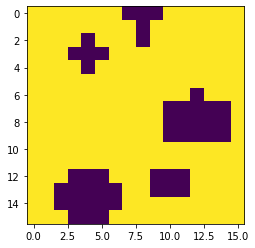

In [121]:
maze = np.array(
[
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
[0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
maze = ~maze+2.0

# maze = maze * 0.0 + 1.0

plt.imshow(maze)

In [122]:
# env = FedRLEnv(maze, cfg_data, start, end)
# env.render()

In [123]:
import numpy as np
from itertools import product
from random import shuffle, seed

def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def create_distance_buckets(env_size, num_buckets):
    free_positions = [(x, y) for x in range(env_size) for y in range(env_size) if env[x][y] != 0]
    all_combinations = list(product(free_positions, repeat=2))
    all_combinations = [(a1, a2) for a1, a2 in all_combinations if a1 != a2]
    
    distances = [(p, manhattan_distance(p[0], p[1])) for p in all_combinations]
    max_distance = max(distances, key=lambda x: x[1])[1]
    bucket_size = max_distance // num_buckets

    buckets = [[] for _ in range(num_buckets)]
    for p, d in distances:
        index = min(d // bucket_size, num_buckets - 1)
        buckets[index].append(p)

    return buckets

def sample_positions(buckets, num_samples):
    samples = []
    samples_per_bucket = num_samples // len(buckets)

    for bucket in buckets:
        shuffle(bucket)
        samples.extend(bucket[:samples_per_bucket])

    return samples

# 设置随机种子
random_seed = 42
seed(random_seed)
np.random.seed(random_seed)

# 创建环境
env_size = 16
env = maze
# env = np.ones((env_size, env_size))
# 假设墙壁位于环境的第一行和最后一行，您可以根据您的实际环境进行修改。
# env[0, :] = 0
# env[-1, :] = 0

num_buckets = 5
train_samples = 1000
test_samples = 1000

buckets = create_distance_buckets(env_size, num_buckets)

train_set = sample_positions(buckets, train_samples)
test_set = sample_positions(buckets, test_samples)

# print("Training Set:", train_set)
# print("Test Set:", test_set)


## Q-maze

In [124]:
# def select_random_points(matrix, n):
#     rows, cols = np.where(matrix == 1)
#     points = list(zip(rows, cols))
#     selected_points = random.sample(points, n)
#     while len(set(selected_points)) < n:
#         selected_points = random.sample(points, n)
#     return selected_points

# a, b = select_random_points(maze, 2)

In [125]:
class Env_Agent:
    def __init__(self, x, y, ob_size=5):  # , agent_id, agent_type, metric_radius=1):
        self.init_x = x
        self.init_y = y
        self.x = x
        self.y = y
        self.path = []
        self.observe_size = ob_size
        self.mark = 2
        self.path_mark = 0.6
        self.status = 'Start'
        self.total_reward = 0

    def reset(self):
        self.x = self.init_x
        self.y = self.init_y
        self.path = []
        self.status = 'Start'
        self.total_reward = 0

In [126]:
# -1/maze.shape[0]

In [127]:
class FedRLEnv:
    """
    The main duties of this wrapper:

    1. Receive inputs and transform outputs as tensors
    2. Normalize states of observations

    """

    def __init__(self, maze, cfg_data, start, end):
        self.visited_mark = 0.5  # Cells visited by the rat will be painted by gray 0.8
        self.end_mark = 3
        self.rat_mark = 2  # The current rat cell will be painteg by gray 0.5
        self.LEFT = 0
        self.UP = 1
        self.RIGHT = 2
        self.DOWN = 3
        self.cfg_data = cfg_data

        # 允许的最大步数
        self.max_Tstep = cfg_data.max_Tstep
        self.action_space = [0, 1, 2, 3]
        # 初始化迷宫，老鼠可以从任意位置开始，默认为左上角
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape

        self.name = 'FedRL_env'
        # self.agents = []
        self.agent_dict = edict()
#         self.agent_dict.alpha = Env_Agent(cfg_data.rat[0], cfg_data.rat[1], 3)  # rat
#         if cfg_data.target is None:
#             self.agent_dict.beta = Env_Agent(nrows - 1, ncols - 1, 3)  # target
#         else:
#             self.agent_dict.beta = Env_Agent(cfg_data.target[0], cfg_data.target[1], 3)

#         position_alpha, position_beta = select_random_points(self._maze, 2)
        self.agent_dict.alpha = Env_Agent(start[0], start[1], 5)
        self.agent_dict.beta = Env_Agent(end[0], end[1], 5)

        self.agent_dict.alpha.mark = self.rat_mark
        self.agent_dict.beta.mark = self.end_mark
        self.agent_dict.alpha.path_mark = 0.4
        self.agent_dict.beta.path_mark = 0.6

        # 终点可以是任意位置
        # if cfg_data.target is None:
        #     self.target = (nrows - 1, ncols - 1)  # target cell where the "cheese" is
        # else:
        #     self.target = cfg_data.target
        # # 初始化空格list，maze为1表示空格，为0表示墙体
        # self.free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 1.0]
        # # 将目标格移出空格list
        # self.free_cells.remove(self.target)
        # 检查左上和右下是否为空
#         if self._maze[self.agent_dict.beta.x, self.agent_dict.beta.y] == 0.0:
#             raise Exception("Invalid maze: target cell cannot be blocked!")
#         if self._maze[self.agent_dict.alpha.x, self.agent_dict.alpha.y] == 0.0:
#             raise Exception("Invalid Rat Location: must sit on a free cell")
        # 放置两个agent并初始化参数
        self.reset()

    def reset(self):
        
        
        
        self.maze = np.copy(self._maze)  # self.maze is the maze that will be modified during the simulation
        for _, agent in self.agent_dict.items():
            agent.reset()

        nrows, ncols = self.maze.shape
        alpha_x = self.agent_dict.alpha.x
        alpha_y = self.agent_dict.alpha.y
        beta_x = self.agent_dict.beta.x
        beta_y = self.agent_dict.beta.y
        self.maze[alpha_x, alpha_y] = self.rat_mark
        self.maze[beta_x, beta_y] = self.end_mark

        # 初始状态
        # self.state = (row, col, 'start')
        # 设置最低奖励阈值
#         self.min_reward = 38 * self.cfg_data.REWARD.WALL  # -0.5 * self.maze.size
        # 初始化总奖励
        # self.total_reward = 0
        self.total_Tstep = 0

        t_observations = {name: self.get_observation(agent) for name, agent in self.agent_dict.items()}

        # self.visited = list()
        # for _, agent in self.agent_dict.items():
        #     agent.path = []
        #     agent.status = 'Start'
        #     agent.total_reward = 0

        return t_observations, self.game_status()

    def get_observation(self, agent):
        maze = np.copy(self._maze)

        # draw the rat
        for name, _agent in self.agent_dict.items():
            maze[_agent.x, _agent.y] = _agent.mark

        size = agent.observe_size

        row, col = agent.x, agent.y
        # 获取maze的行列数
        ROWS = len(maze)
        COLS = len(maze[0])

        # 初始化结果二维数组
        result = [[0 for _ in range(size)] for _ in range(size)]

        # 将以指定点为中心指定尺寸范围的观测值存入结果二维数组
#         print(row - size // 2, row + size // 2 + 1)
#         print(col, row, size)
        for i in range(row - size // 2, row + size // 2 + 1):
            for j in range(col - size // 2, col + size // 2 + 1):
                if i < 0 or i >= ROWS or j < 0 or j >= COLS:
                    # 如果超出边界，则填充为0
                    result[i - row + size // 2][j - col + size // 2] = 0.0
                else:
                    result[i - row + size // 2][j - col + size // 2] = maze[i][j]

        # 返回结果二维数组
        result = np.array(result)
        result[size // 2][size // 2] = agent.mark
        return result

    def render(self):
        plt.grid('on')
        ax = plt.gca()
        nrows, ncols = self.maze.shape
        ax.set_xticks(np.arange(0.5, nrows, 1))
        ax.set_yticks(np.arange(0.5, ncols, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        canvas = np.copy(self.maze)

        for k, agent in self.agent_dict.items():

            for row, col in agent.path:
                # if canvas[row, col] == 1.0:
                canvas[row, col] = agent.path_mark
                # else:
                #     canvas[row, col] = self.visited_mark

        alpha_x = self.agent_dict.alpha.x
        alpha_y = self.agent_dict.alpha.y
        beta_x = self.agent_dict.beta.x
        beta_y = self.agent_dict.beta.y
        canvas[alpha_x, alpha_y] = 0.5
        canvas[beta_x, beta_y] = 0.6
        plt.imshow(canvas, interpolation='none', cmap='gray')
        plt.show()
        # return img

    def step(self, action_dict):
        self.update_state(action_dict)

        t_observations = {name: self.get_observation(agent) for name, agent in self.agent_dict.items()}
        t_rewards = self.get_reward()
        info = self.game_status()
        done = (info != 'not_over')
#         print('info', info)
#         print('done', done)

        return t_observations, t_rewards, done, info

    def game_status(self):
        flag = 1

        # 如果所有老鼠的奖励都小于最低奖励阈值，则游戏结束
#         for name, agent in self.agent_dict.items():
#             if agent.total_reward > self.min_reward:
#                 flag = 1

        if self.total_Tstep > self.max_Tstep or flag == 0:
            # if self.total_reward < self.min_reward:
            # if self.total_Tstep > self.max_Tstep:
            return 'lose'

        if self.get_distance() <= 1:
            return 'win'

        return 'not_over'

    def update_state(self, action_dict):
        '''
            input: {'alpha': t_alpha_action, 'beta': t_beta_action} [0, 1, 2, 3] [L, U, R, D]
        '''
        for name, agent in self.agent_dict.items():
            action = action_dict[name]

            # 如果老鼠访问的是空格，则记录
            if self.maze[agent.x, agent.y] > 0.0:
                agent.path.append((agent.x, agent.y))  # mark visited cell

            # 获取所有可能执行的动作
            valid_actions = self.valid_actions(name)
            # print('valid_actions', valid_actions)

            # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
            if not valid_actions:
                agent.status = 'blocked'
                print('blocked')
            # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
            elif action in valid_actions:
                agent.status = 'valid'
                if action == self.LEFT:
                    agent.y -= 1
                elif action == self.UP:
                    agent.x -= 1
                if action == self.RIGHT:
                    agent.y += 1
                elif action == self.DOWN:
                    agent.x += 1
            # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
            else:  # invalid action, no change in rat position
                agent.status = 'invalid'

        # 两次动作都执行完毕后，更新步数
        self.total_Tstep += 1  # 每次执行动作+1

    def valid_actions(self, agent_name):
        # print('agent_name', agent_name)
        # print(self.agent_dict)
        agent = self.agent_dict[agent_name]
        # 默认验证当前位置
        row, col = agent.x, agent.y
        actions = copy.deepcopy(self.action_space)
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows - 1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols - 1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row > 0 and self.maze[row - 1, col] == 0.0:
            actions.remove(1)
        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col > 0 and self.maze[row, col - 1] == 0.0:
            actions.remove(0)
        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions

    def get_reward(self):

        # nrows, ncols = self.maze.shape
        # reward = 0
        L1_distance = self.get_distance()
        if L1_distance <= 1:
            t_rewards = dict()
            for name, agent in self.agent_dict.items():
                t_rewards[name] = self.cfg_data.REWARD.WIN
                agent.total_reward += self.cfg_data.REWARD.WIN
                agent.path.append((agent.x, agent.y))  # mark visited cell
            return t_rewards

        if self.cfg_data.REWARD.HEURISTIC:
            # 估计距离
            rg = -L1_distance/self._maze.shape[0]
#             rg = self._maze.shape[0] / L1_distance
            # rg = 1 / L1_distance
        else:
            rg = 0

        t_rewards = dict()
        for name, agent in self.agent_dict.items():
            rl = 0
            if L1_distance <= 1:
                rl = self.cfg_data.REWARD.WIN  # 奶酪，给予 1.0 分
            # elif mode == 'blocked':
            #     rl = self.min_reward - 1
            elif agent.status == 'invalid':
                rl = self.cfg_data.REWARD.WALL  # 撞墙-0.75 分，动作不会被执行
            # elif (rat_row, rat_col) in self.visited:
            #     rl = self.cfg_data.REWARD.VISITED  # 访问已经访问过的单元格，-0.25 分
            elif agent.status == 'valid':
                rl = self.cfg_data.REWARD.MOVE  # 每次移动都会花费老鼠 -0.04 分

            reward = rl + rg

            t_rewards[name] = reward
            agent.total_reward += reward

        return t_rewards

    def get_distance(self):
        rat_row, rat_col = self.agent_dict.alpha.x, self.agent_dict.alpha.y
        target_row, target_col = self.agent_dict.beta.x, self.agent_dict.beta.y
        L1_distance = abs(rat_row - target_row) + abs(rat_col - target_col)

        return L1_distance

## DQN - Agent

In [128]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, observation_size, maze_size, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(observation_size, 32)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, num_actions)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x


In [129]:
# import torch
# import torch.nn as nn

# class DQN(nn.Module):
#     def __init__(self):
#         super(DQN, self).__init__()

#         # 定义卷积层
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()

#         # 定义全连接层
#         self.fc2 = nn.Linear(in_features=16*3*3, out_features=32)
#         self.relu2 = nn.ReLU()

#         # 定义输出层
#         self.fc3 = nn.Linear(in_features=32, out_features=4)
# #         self.relu3 = nn.ReLU()

#     def forward(self, x):
#         # 前向传播过程
#         x = x.unsqueeze(0).unsqueeze(0) # 将输入变为 1x1x3x3
#         x = self.relu1(self.conv1(x))
#         x = x.view(-1, 16*3*3)
#         x = self.relu2(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # 创建模型实例
# net = DQN()

# # 测试模型
# input = torch.rand(3,3)
# output = net(input)
# print(output)


## utils

In [130]:
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
# set up matplotliba
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def moving_average(data_list, window_size=100):
    moving_averages = []
    for i in range(len(data_list)):
        if i < window_size:
            window_data = data_list[:i + 1]
        else:
            window_data = data_list[i - window_size + 1:i + 1]
        average = sum(window_data) / len(window_data)
        moving_averages.append(average)
    
    return moving_averages

In [131]:
class Agent:
    def __init__(self, agent_id, observation_size, cfg_):
        observation_size = observation_size ** 2
        self.observation_size = observation_size
        self.cfg = cfg_

        self.policy_net = DQN(observation_size, self.cfg.maze_size, self.cfg.num_actions).to(device)
        self.target_net = DQN(observation_size, self.cfg.maze_size, self.cfg.num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.cfg.LR)
        self.agent_id = agent_id

        self.memory = ReplayMemory(2000)

        self.episode_rewards = []
        self.episode_step = []

        self.steps_done = 0

    # 动作选取
    def select_action(self, state, env=None):
        sample = random.random()

        # 随着进行，eps_threshold逐渐降低
        eps_threshold = self.cfg.EPS_END + (self.cfg.EPS_START - self.cfg.EPS_END) * \
            math.exp(-1. * self.steps_done / self.cfg.EPS_DECAY)

        # eps_threshold = self.cfg.eps_threshold

        self.steps_done += 1

        # 常规情况选择价值最高的动作
        if sample > eps_threshold:
#             print('利用')
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # print(state)
                # state = torch.tensor(state, dtype=torch.float32, device=device).reshape((1, -1))
                # print(state)
                return self.policy_net(state).max(1)[1].view(1, 1)

        # 当随机值超过阈值时，随机选取 - exploration
        else:
#             print('随机')
            # 探索时只探索可能的动作，增加探索效率？
            return torch.tensor([[random.choice(env.valid_actions(self.agent_id))]], device=device,
                                dtype=torch.long)

    def train(self):
#         print(len(self.memory), self.cfg.BATCH_SIZE)
        if len(self.memory) < self.cfg.BATCH_SIZE:
            return

        # 离线学习，从记忆池中抽取回忆
        transitions = self.memory.sample(self.cfg.BATCH_SIZE)
        # print(transitions)

        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.

        # 将([a, 1], [b, 2], [c, 3])转化为([a, b, c], [1, 2, 3])，一个zip的trick
        # 然后将他们分别放到tuples with names里（'state', 'action', 'next_state', and 'reward'）
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        # 计算非最终状态的掩码，并将批处理元素连接起来
        # (最终状态是指模拟结束后的状态)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        # 模型计算Q价值，我们根据价值选择动作
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.cfg.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        # 当前奖励+下一个状态的奖励，更新Q. 如果下一个状态为最终状态，则仅有当前奖励
        expected_state_action_values = (next_state_values * self.cfg.GAMMA) + reward_batch
        # print(expected_state_action_values)

        # Compute Huber loss
#         criterion = nn.SmoothL1Loss()
        criterion = nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
#         torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    # soft_sync_target_net
    def soft_sync_target_net(self):
        # self.target_net.load_state_dict(self.policy_net.state_dict())
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()

        # if (steps_done % sync_target_net_freq) == 0:
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.cfg.TAU \
                                         + target_net_state_dict[key] * (1 - self.cfg.TAU)

        self.target_net.load_state_dict(target_net_state_dict)

In [132]:
# torch.tensor([[random.choice([0, 1, 2, 3])]], device=device,
#                                 dtype=torch.long)

In [133]:
len(test_set)

1000

In [134]:
def evaluation(pure_random = False):
    
    win = 0
    # episode_rewards_eval = []
    episode_rewards_alpha_eval = []
    episode_rewards_beta_eval = []
    episode_step_eval = []
    
    for i in trange(len(test_set)):
    
        # 读取训练集
#         maze = np.array(test_dict['gridworld'][i])*1.0
        start = test_set[i][0]
        end = test_set[i][1]

        optimal_length = 86
        env_eval = FedRLEnv(maze, cfg_data, start, end)
        env_eval.max_Tstep = optimal_length

#         for j in range(1):
        # Initialize the environment and get it's state
        state, info = env_eval.reset()

        done = False
        while not done:
            # 环境观察到的两个状态分别分配给两个agent
            state_alpha = torch.tensor(state['alpha'], dtype=torch.float32, device=device).reshape((1, -1))
            state_beta = torch.tensor(state['beta'], dtype=torch.float32, device=device).reshape((1, -1))

            if not pure_random:
                with torch.no_grad():
                    action_alpha = Agent_alpha.policy_net(state_alpha).max(1)[1].view(1, 1)  # 选择一个动作
                    action_beta = Agent_beta.policy_net(state_beta).max(1)[1].view(1, 1)  # 选择一个动作
            else:
                action_alpha = torch.tensor([[random.choice([0, 1, 2, 3])]], device=device,
                                dtype=torch.long)
                action_beta = torch.tensor([[random.choice([0, 1, 2, 3])]], device=device,
                                dtype=torch.long)
                

            t_actions = {'alpha': action_alpha.item(), 'beta': action_beta.item()}

            # random.choice(env.valid_actions())
            t_observations, t_rewards, done, info = env_eval.step(t_actions)  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            # observation_alpha = torch.tensor(t_observations['alpha'], dtype=torch.float32, device=device).reshape((1, -1))
            # observation_beta = torch.tensor(t_observations['beta'], dtype=torch.float32, device=device).reshape((1, -1))
            #
            # if done:
            #     next_state_alpha = next_state_beta = None
            # else:  # 如果没有终止则继续记录下一个状态
            #     next_state_alpha = observation_alpha
            #     next_state_beta = observation_beta

            state = t_observations
            # # Store the transition in memory
            # # memory.push(state, action, next_state, reward)
            #
            # # Move to the next state
            # state = t_observations

        episode_rewards_alpha_eval.append(env_eval.agent_dict.alpha.total_reward)
        episode_rewards_beta_eval.append(env_eval.agent_dict.beta.total_reward)
        episode_step_eval.append(env_eval.total_Tstep)
        
        history.alpha_eval_path.append(env_eval.agent_dict['alpha'].path)
        history.beta_eval_path.append(env_eval.agent_dict['beta'].path)
        
#         env_eval.render()
#         if i >= 10:
#             break

        if info == 'win':  #  and env.total_Tstep<=optimal_length:
            win += 1
            history.win_eval.append(1)
        else:
            history.win_eval.append(0)
#         elif info == 'win':
#             win = 0.5
#         else:
#             win = 0

    win_rate = win / len(test_set)

    # env.render()
    # print(env.visited)
    # print(env.state)
    # print(env.total_reward)

    return [episode_rewards_alpha_eval, episode_rewards_beta_eval, episode_step_eval], win_rate

In [135]:
# evaluation()

## train

In [136]:


# episode_rewards.append(env.total_reward)
# episode_step.append(t)
# win_eval.append(win_rate)
# episode_rewards_eval_list.append(episode_rewards_eval)
# #     loss_train.append(acc_loss)
# val_visited_list.append(val_visited)
# history['episode_rewards'] = episode_rewards
# history['episode_step'] = episode_step
# history['win_eval'] = win_eval
# history['loss_train'] = loss_train
# history['val_visited_list'] = val_visited_list
# history['episode_rewards_eval_list'] = val_visited_list

In [137]:
# self.LEFT = 0
# self.UP = 1
# self.RIGHT = 2
# self.DOWN = 3

In [138]:
len(train_set)

1000

In [139]:
def plot_rewards(episode_rewards, show_result=False, zero_point=None, ylabel='Rewards'):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(rewards_t.cpu().numpy())
    
    if zero_point is None:
        zero_point = (8*8*0.5)
    
    # Take 100 episode averages and plot them too
    moving_averages = moving_average(episode_rewards, 100)
    plt.plot(moving_averages)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [140]:
from itertools import count
from tqdm import trange

history = edict()

def train():
    
    

    history.episode_rewards_alpha = []
    history.episode_rewards_beta = []
    history.episode_step = []
    history.win_eval = []
    history.loss_train = []
    history.val_visited_list = []
    history.episode_rewards_eval_list = []

    history.alpha_eval_path = []
    history.beta_eval_path = []

    for i in trange(len(train_set)):

        # 读取训练集
    #     maze = np.array(train_dict['gridworld'][i])*1.0
        start = train_set[i][0]
        end = train_set[i][1]

    #     maze = np.loadtxt('games/GridWorld/maze8_0.1_5.txt')
        #
        env = FedRLEnv(maze, cfg_data, start, end)

        # 初始化测试环境
    #     optimal_length = 38
    #     env_eval = FedRLEnv(maze, cfg_data)
    #     env_eval.max_Tstep = optimal_length*2


        for i_episode in range(cfg.num_episodes):
        # for i_episode in trange(1):
            # Initialize the environment and get it's state
            state, info = env.reset()

            # 环境观察到的两个状态分别分配给两个agent
            # state = torch.tensor(state, dtype=torch.float32, device=device).reshape((1, -1))
            state_alpha = torch.tensor(state['alpha'], dtype=torch.float32, device=device).reshape((1, -1))
            state_beta = torch.tensor(state['beta'], dtype=torch.float32, device=device).reshape((1, -1))

            done = False
            for t in count():
        #         env.render()

                action_alpha = Agent_alpha.select_action(state_alpha, env)  # 选择一个动作
                action_beta = Agent_beta.select_action(state_beta, env)  # 选择一个动作

        #         print(action_alpha, action_beta)
                t_actions = {'alpha': action_alpha.item(), 'beta': action_beta.item()}
        #         print(t_actions)
                t_observations, t_rewards, done, info = env.step(t_actions)  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
        #         print(f't_observations {t_observations}, t_rewards {t_rewards}, done {done}, info {info}')
        #         env.render()

                reward_alpha = torch.tensor([t_rewards['alpha']], device=device)
                reward_beta = torch.tensor([t_rewards['beta']], device=device)

                observation_alpha = torch.tensor(t_observations['alpha'], dtype=torch.float32, device=device).reshape((1, -1))
                observation_beta = torch.tensor(t_observations['beta'], dtype=torch.float32, device=device).reshape((1, -1))

                if done:
                    next_state_alpha = next_state_beta = None
                else:  # 如果没有终止则继续记录下一个状态
                    next_state_alpha = observation_alpha
                    next_state_beta = observation_beta

                # print(reward_alpha, reward_beta)
                # print(observation_alpha, observation_beta)
                # print(next_state_alpha, next_state_beta)

                # break
                # Store the transition in memory
                Agent_alpha.memory.push(state_alpha, action_alpha, next_state_alpha, reward_alpha)
                Agent_beta.memory.push(state_beta, action_beta, next_state_beta, reward_beta)
        #         print( f'State: {state_alpha}, Action: {action_alpha}, Next state: {next_state_alpha}, Reward: {reward_alpha}')

                # Move to the next state
                # state = next_state
                state_alpha = next_state_alpha
                state_beta = next_state_beta

                # Perform one step of the optimization (on the policy network)
                Agent_alpha.train()
                Agent_beta.train()

                # Soft update of the target network's weights
                Agent_alpha.soft_sync_target_net()
                Agent_beta.soft_sync_target_net()

                if done:
                    break

            Agent_alpha.episode_rewards.append(env.agent_dict.alpha.total_reward)
            Agent_beta.episode_rewards.append(env.agent_dict.beta.total_reward)

    #         plot_rewards(Agent_alpha.episode_rewards)

            Agent_alpha.episode_step.append(env.total_Tstep)
            Agent_beta.episode_step.append(env.total_Tstep)

    #         [episode_rewards_alpha_eval, episode_rewards_beta_eval, episode_step_eval], win_eval = evaluation()
    #         history.alpha_eval_path.append(env_eval.agent_dict['alpha'].path)
    #         history.beta_eval_path.append(env_eval.agent_dict['beta'].path)
    #         history.win_eval.append(win_eval)


        #     print('Episode {}\tLast num step: {:.2f}\tLast reward Alpha: {:.2f}\t'
        #           'Last reward Beta: {:.2f}\tInfo: {}\tEval: {}'
        #           .format(i_episode, env.total_Tstep, env.agent_dict.alpha.total_reward,
        #                   env.agent_dict.beta.total_reward, info, win_eval))





    # history.loss_train = []
    # history.val_visited_list = []
    # history.episode_rewards_eval_list = []

    history.episode_rewards_alpha = Agent_alpha.episode_rewards
    history.episode_rewards_beta = Agent_beta.episode_rewards
    history.episode_step = Agent_alpha.episode_step

In [141]:
wins = []
history_list = []
all_history_list = []

In [142]:
# random.shuffle(train_set)

In [143]:
from tqdm import trange

for i in range(1):
    Agent_alpha = Agent('alpha', 5, cfg)
    Agent_beta = Agent('beta', 5, cfg)
    
    train()
#     [episode_rewards_alpha_eval, episode_rewards_beta_eval, episode_step_eval], win_eval = evaluation(pure_random=False)
    
#     wins.append(win_eval)
    history_list.append(copy.deepcopy(history))
all_history_list.append(copy.deepcopy(history_list))

 62%|██████▏   | 619/1000 [30:46<18:56,  2.98s/it] 


KeyboardInterrupt: 

In [144]:
[episode_rewards_alpha_eval, episode_rewards_beta_eval, episode_step_eval], win_eval = evaluation(pure_random=False)

wins.append(win_eval)

100%|██████████| 1000/1000 [00:38<00:00, 25.81it/s]


In [ ]:
# [episode_rewards_alpha_eval, episode_rewards_beta_eval, episode_step_eval], win_eval = evaluation(pure_random=False)

In [ ]:
# all_history_list.append(copy.deepcopy(history_list))

In [145]:
wins

[0.071]

In [64]:
import numpy as np

data = wins[0:3]
mean = np.mean(data)
std_error = np.std(data, ddof=1) / np.sqrt(len(data))

print("Mean:", mean)
print("Standard Error:", std_error)
print(f'{mean*100:.1f}±{std_error/2*100:.1f}')

Mean: nan
Standard Error: nan
nan±nan


In [65]:
# history

In [66]:
# history = history_list[0]

In [67]:
# all_history_list = [[history]]

In [68]:
def plot_history(episode_history, title='Result', ylabel='Rewards', hline=None, y_upper=None, y_lower=None, window_size=100):
    plt.figure()
    plt.title(title)
    plt.xlabel('episode')
    plt.ylabel(ylabel)
    
    if hline is not None:
        plt.axhline(y=hline, color='Red', linestyle='--')
    if y_upper is not None and y_lower is not None:
        plt.ylim([y_lower, y_upper])
    
    plt.plot(episode_history)
    
    moving_averages = moving_average(episode_history, window_size)
    plt.plot(moving_averages)
    
    plt.show()

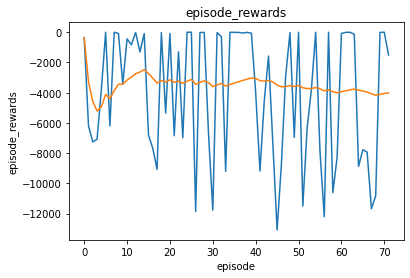

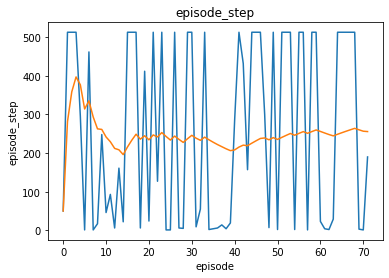

In [70]:
plot_history(Agent_alpha.episode_rewards, 'episode_rewards', 'episode_rewards')  # , y_upper=1, y_lower=0
# plot_history(Agent_beta.episode_rewards, 'beta episode_rewards', 'episode_rewards')
plot_history(Agent_alpha.episode_step, 'episode_step', 'episode_step')
# plot_history(history.win_eval, 'eval_win_rate', 'eval_win_rate')

# env.render()
# env_eval.render()

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# 定义一个函数来计算均值和90%置信区间
def mean_and_confidence_interval(rewards_data):
    mean_rewards = np.mean(rewards_data, axis=0)
    std_rewards = np.std(rewards_data, axis=0)
    confidence_interval = 1.645 * std_rewards / np.sqrt(rewards_data.shape[0]) # 1.645 对应于90%置信区间; 1.96 95%
    return mean_rewards, confidence_interval

def plot_conf_map(labels, key, hline=None, y_lim=None, window_size=5):
    # 设置图片大小
    plt.figure(figsize=(10, 6))
    # 打开网格
    plt.grid(True)
    
    color_maps = ['#6CACE4', '#F79646', '#82B366', '#E46D76', '#F3CC56', '#89C1C8']

    for ahl_i in range(len(all_history_list)):
        plot_data_list = []
        for i in range(num_runs):
            plot_data_list.append(all_history_list[ahl_i][i][key])
        plot_data_list = np.array(plot_data_list)

        # 计算两个算法的均值和置信区间
        mean_rewards_algo1, ci_algo1 = mean_and_confidence_interval(plot_data_list)
        # mean_rewards_algo2, ci_algo2 = mean_and_confidence_interval(rewards_data_algo2)



        # 绘制两个算法的折线图和置信区间
        episodes = np.arange(1, 1000 + 1)
        
#         moving_averages_mean_rewards_algo1 = moving_average(mean_rewards_algo1, window_size=window_size) if window_size>0 else mean_rewards_algo1
        plt.plot(episodes, mean_rewards_algo1, label=labels[ahl_i], color=color_maps[ahl_i])
        plt.fill_between(episodes, mean_rewards_algo1 - ci_algo1, mean_rewards_algo1 + ci_algo1, alpha=0.3, color=color_maps[ahl_i])

    if hline is not None:
        plt.axhline(y=hline, color='Red', linestyle='--')
    if y_lim is not None:
        plt.ylim(y_lim)

    # 设置图表标题和坐标轴标签
    plt.title(f'Mean {key} with 3 times training', fontsize=16)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel(key, fontsize=14)
    plt.legend(fontsize=12)

    # 显示图表
    plt.show()

In [73]:
# all_history_list[0][0].keys()

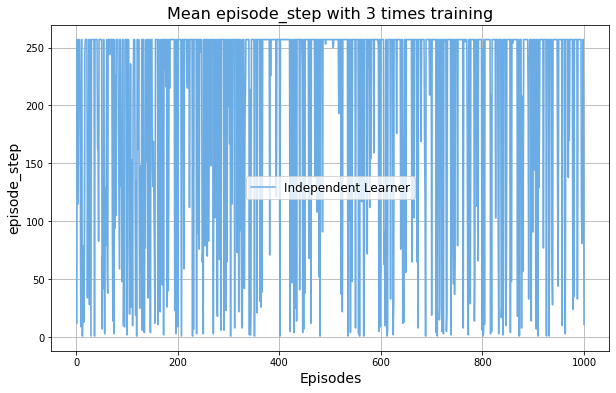

In [74]:
num_runs = 1
labels = ['Independent Learner']
key = 'episode_step'
plot_conf_map(labels, key)

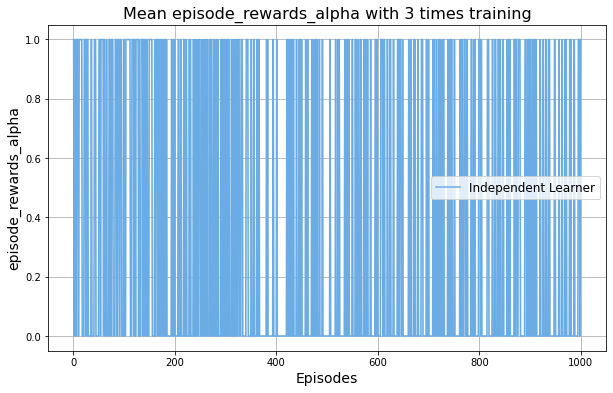

In [75]:
key = 'episode_rewards_alpha'
plot_conf_map(labels, key)

##  可视化路径

In [76]:
# history.alpha_eval_path
# history.beta_eval_path

In [77]:
my_list = history.win_eval
indices_0 = [i for i, x in enumerate(my_list) if x == 0]
indices_05 = [i for i, x in enumerate(my_list) if x == 0.5]
indices_1 = [i for i, x in enumerate(my_list) if x == 1]

print(len(indices_0))   # 输出 [0]
print(len(indices_05))  # 输出 [1]
print(len(indices_1))   # 输出 [2]


885
0
115


In [78]:
print(indices_0)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 21, 22, 23, 24, 25, 26, 29, 30, 33, 40, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 62, 65, 68, 69, 73, 74, 75, 79, 82, 83, 84, 85, 86, 87, 91, 92, 94, 96, 97, 98, 99, 100, 101, 106, 107, 110, 113, 115, 116, 119, 121, 125, 127, 128, 129, 130, 131, 132, 133, 135, 136, 138, 139, 140, 141, 144, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 160, 165, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 265, 266, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 279, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 297, 298, 300, 301, 302, 303, 304, 

In [79]:
print((indices_1))

[0, 10, 11, 13, 14, 15, 16, 18, 19, 20, 27, 28, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 55, 59, 63, 64, 66, 67, 70, 71, 72, 76, 77, 78, 80, 81, 88, 89, 90, 93, 95, 102, 103, 104, 105, 108, 109, 111, 112, 114, 117, 118, 120, 122, 123, 124, 126, 134, 137, 142, 143, 145, 146, 156, 158, 159, 161, 162, 163, 164, 166, 167, 168, 169, 170, 181, 185, 188, 196, 215, 219, 242, 247, 260, 264, 269, 278, 286, 296, 299, 305, 312, 315, 323, 324, 326, 329, 332, 351, 354, 360, 363, 366, 377, 385, 393, 422, 439, 455, 456, 470, 493, 570]


In [84]:
index = 609
print(index)

path1 = history.alpha_eval_path[index]
path2 = history.beta_eval_path[index]

609


In [85]:
hot_map = np.zeros((16, 16))

In [86]:
hot_map[path1[-1]]

0.0

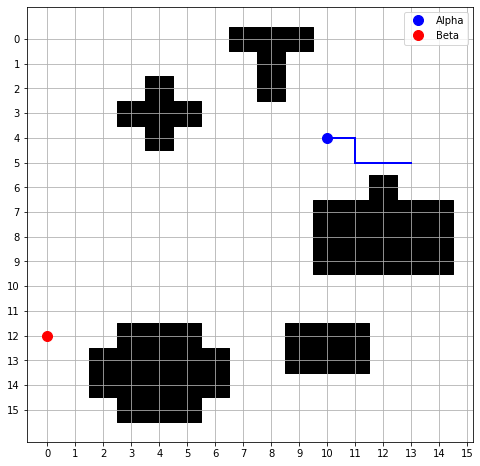

path1 [(4, 10), (4, 11), (5, 11), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13), (5, 12), (5, 13)]
path2 [(12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 0), (12, 

In [87]:
start, end = test_set[index]
def visualize_path(maze, paths, colors):
    maze_size = len(maze)
    plt.figure(figsize=(maze_size/2, maze_size/2))

    # Draw obstacles
    for i in range(maze_size):
        for j in range(maze_size):
            if maze[i][j] == 0:
                plt.fill_between([j-.5, j+1-.5], i-.5, i+1-.5, color='black')

    # Draw the paths
    for path_idx, path in enumerate(paths):
        for index, position in enumerate(path[:-1]):
            plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color=colors[path_idx], linewidth=2)

    plt.plot(start[1], start[0], 'bo', markersize=10, label='Alpha')  # start point
    plt.plot(end[1], end[0], 'ro', markersize=10, label='Beta')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

visualize_path(maze, [path1, path2], ['blue', 'red'])
print('path1', path1)
print('path2', path2)

## 路径热力图

In [116]:
hot_map_meetingpoint = np.zeros((16, 16))
for index in range(1000):
# for index in indices_1:
    path1 = history.alpha_eval_path[index]
    path2 = history.beta_eval_path[index]
    
    hot_map_meetingpoint[path1[-1]] += 1
    hot_map_meetingpoint[path2[-1]] += 1

In [117]:
hot_map_path = np.zeros((16, 16))
for index in range(1000):
# for index in indices_1:
    path1 = history.alpha_eval_path[index]
    path2 = history.beta_eval_path[index]
    
    for p in range(len(path1)):
        hot_map_path[path1[p]] += 1
        hot_map_path[path2[p]] += 1

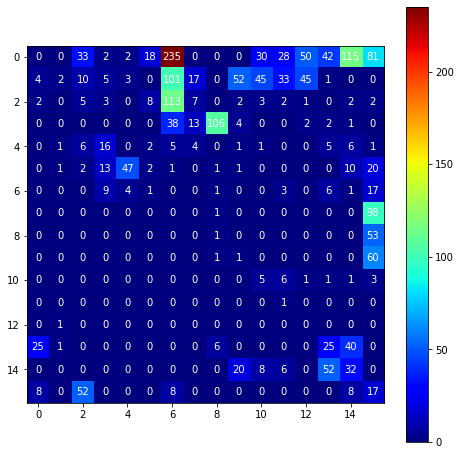

In [118]:
def draw_heat_map(data):
    # 绘制热力图
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data, cmap='jet')

    # 在每个格子中显示数字
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j, i, f"{int(data[i, j])}",
                           ha="center", va="center", color="w")

    # 添加颜色条
    fig.colorbar(im)

    # 显示图形
    plt.show()

draw_heat_map(hot_map_meetingpoint)

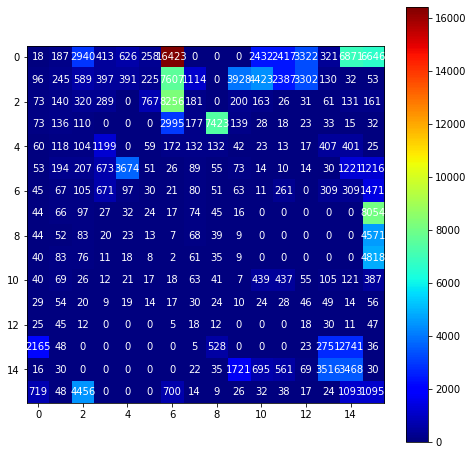

In [119]:
draw_heat_map(hot_map_path)

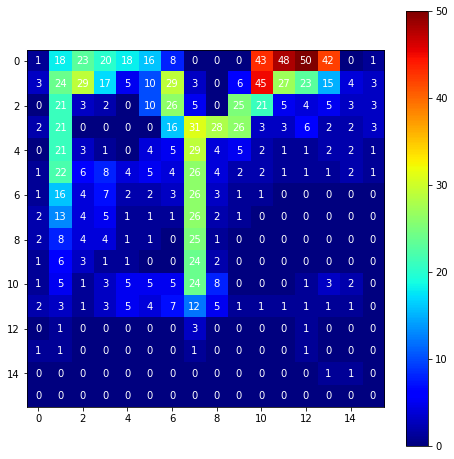

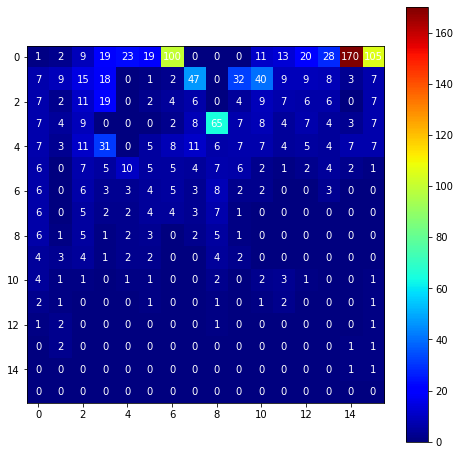

In [126]:
hot_map_path_a = np.zeros((16, 16))
hot_map_path_b = np.zeros((16, 16))
# for index in range(1000):
for index in indices_1:
    path1 = history.alpha_eval_path[index]
    path2 = history.beta_eval_path[index]
    
    for p in range(len(path1)):
        hot_map_path_a[path1[p]] += 1
        hot_map_path_b[path2[p]] += 1
        
draw_heat_map(hot_map_path_a)
draw_heat_map(hot_map_path_b)

In [127]:
hot_map_path.shape

(16, 16)

In [128]:
alpha_set = []
beta_set = []
hot_map_start = np.zeros((16, 16))
for a, b in train_set:
    hot_map_start[a] += 1
    hot_map_start[b] += 1
#     beta_set.append(b)

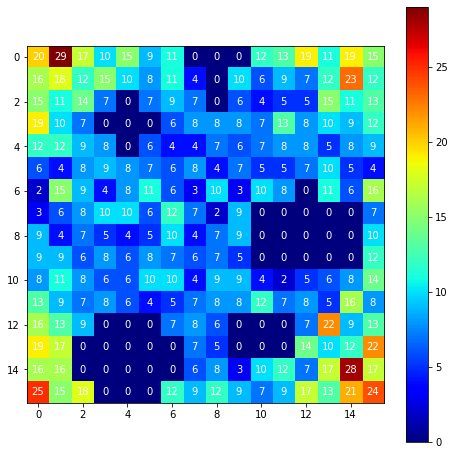

In [113]:
draw_heat_map(hot_map_start)

In [114]:
alpha_set = []
beta_set = []
hot_map_start_eval = np.zeros((16, 16))
for a, b in test_set:
    hot_map_start_eval[a] += 1
    hot_map_start_eval[b] += 1
#     beta_set.append(b)

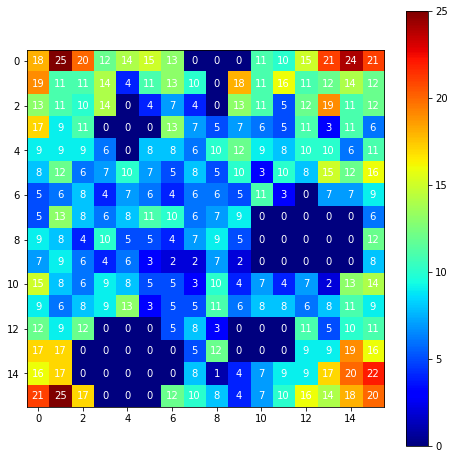

In [115]:
draw_heat_map(hot_map_start_eval)

In [51]:
# maze = np.array(test_dict['gridworld'][index])*1.0
# start = test_dict['start'][index]
# end = test_dict['end'][index]

In [146]:
TASK_NAME = 'openmap-independent'

In [147]:
now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
save_path = f"runs/grid_16_meet/{ENV_NAME}/" + TASK_NAME +'/'+ now

In [155]:
save_path

'runs/grid_16_meet/grid-double-agent-single-map/openmap-independent/04-24_21-15-12'

In [156]:
os.makedirs(save_path, exist_ok=True)

In [157]:
# 将字典保存成 txt 文件
with open(save_path+'/config.txt', 'w') as f:
    for key, value in cfg.items():
        f.write(f'{key}: {value}\n')

In [158]:
# 将字典保存成 txt 文件
with open(save_path+'/config_data.txt', 'w') as f:
    for key, value in cfg_data.items():
        f.write(f'{key}: {value}\n')

In [159]:
len(all_history_list)

1

In [160]:
for history in history_list:
    # 将字典保存成 txt 文件
    with open(save_path+'/history.txt', 'w') as f:
        for key, value in history.items():
            f.write(f'{key}: {value}\n')

In [161]:
torch.save(Agent_alpha.policy_net, save_path + '/agent_policy.pth')

In [162]:
torch.save(Agent_beta.policy_net, save_path + '/beta_policy.pth')

In [ ]:
print(cfg)

In [ ]:
save_path

In [ ]:
# def display_maze_and_path(maze, path):
#     # Create a grid with obstacles, visited cells, rat and end positions
#     grid_with_path = maze.copy()

#     # Mark the visited cells and path positions
#     for position in path:
#         if grid_with_path[position] == 1:  # Check if it's a free cell
#             grid_with_path[position] = visited_mark-0.3

#     # Mark the start (rat) and end positions
#     start, end = path[0], (7, 7)
#     grid_with_path[start] = rat_mark
#     grid_with_path[end] = end_mark
#     print(grid_with_path)

#     # Display the grid
#     plt.imshow(grid_with_path, cmap="coolwarm")
#     plt.colorbar()
#     plt.show()

In [ ]:
# def display_maze_and_path(maze, path):
#     # Switch 0 and 1 in the maze
# #     maze = 1 - maze
    
#     visited_mark = 0.6  # Cells visited by the rat will be painted by gray 0.6
#     end_mark = 0.8
#     rat_mark = 0.4      # The current rat cell will be painted by gray 0.4

#     # Create a grid with obstacles, visited cells, rat and end positions
#     grid_with_path = maze.copy()

#     # Initialize a visits grid
#     visits_grid = np.zeros(maze.shape, dtype=int)

#     # Mark the visited cells and path positions
#     for position in path:
#         if grid_with_path[position] == 1:  # Check if it's a free cell
#             visits_grid[position] += 1

#     # Normalize the visits grid to a range between visited_mark and rat_mark
#     print(visits_grid)
#     visits_grid = (visits_grid / (visits_grid.max()/0.9))
# #     print(visits_grid)

#     # Overlay the visits grid on the maze
# #     grid_with_path[np.where(visits_grid > visited_mark)] = visits_grid[np.where(visits_grid > visited_mark)]
#     grid_with_path += visits_grid
# #     print(grid_with_path)

#     # Mark the start (rat) and end positions
#     start, end = path[0], (15, 15)
# #     grid_with_path[start] = 0.1
#     grid_with_path[end] = 0.9
# #     print(grid_with_path)

#     # Display the grid
#     plt.imshow(grid_with_path, cmap="gray")  # coolwarm
#     plt.colorbar()
#     plt.show()

In [ ]:
def visualize_path(maze_size, path):
    grid = np.zeros((maze_size, maze_size))
    plt.figure(figsize=(maze_size/2, maze_size/2))

    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 1]

print(indices_of_ones)

In [ ]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value > 0 and value < 1]

print(indices_of_ones)

In [ ]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 0]

print(indices_of_ones)

In [ ]:
path = history['val_visited_list'][70]
print(path)

In [ ]:
def visualize_path(maze, path):
    maze_size = len(maze)
    plt.figure(figsize=(maze_size/2, maze_size/2))

    # Draw obstacles
    for i in range(maze_size):
        for j in range(maze_size):
            if maze[i][j] == 0:
                plt.fill_between([j-.5, j+1-.5], i-.5, i+1-.5, color='black')

    # Draw the path
    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
# maze_size = 8
print("Steps:", len(path))
visualize_path(maze, path)

In [ ]:
len(episode_rewards)

In [ ]:
# Initialize the environment and get it's state
state, info = env.reset()
# Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
state = torch.tensor(state, dtype=torch.float32, device=device)

done = False
while not done:
    print(state)
    action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
    # random.choice(env.valid_actions())
    observation, reward, done, _ = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
    # reward = torch.tensor([reward], device=device)

    if done:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

    # Store the transition in memory
    # memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    

In [ ]:
show(env)
print(env.visited)
print(env.total_reward)

In [ ]:
policy_net.cpu()

In [ ]:
# Actions dictionary
actions_dict = {
    LEFT: 'left',  # 0
    UP: 'up',      # 1
    RIGHT: 'right',# 2
    DOWN: 'down',  # 3
}

In [ ]:
# step 0
step_0_state = torch.Tensor([[0, 0, 0, 0, 0.5, 1, 0, 1, 1]])
policy_net(step_0_state).max(1)[1].view(1, 1)

In [ ]:
# step 1
step_1_state = torch.Tensor([[0, 1, 1, 0, 0.5, 1, 0, 1, 1]])
policy_net(step_1_state).max(1)[1].view(1, 1)

In [ ]:
# step 2
step_2_state = torch.Tensor([[1, 1, 1, 1, 0.5, 1, 1, 1, 1]])
policy_net(step_1_state).max(1)[1].view(1, 1)

In [ ]:
# step 16
step_16_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 1, 0]])
policy_net(step_16_state).max(1)[1].view(1, 1)

In [ ]:
# step 29
step_29_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 1.5, 0]])
policy_net(step_29_state).max(1)[1].view(1, 1)

In [ ]:
step_29_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 0.8, 0]])
state = step_29_state.reshape((3, 3))
plt.imshow(state, cmap='gray')

In [ ]:
# history['test_route'] = env.visited
# history['test_total_reward'] = env.total_reward

# # 将字典保存成 txt 文件
# with open(folder_name+'/history.txt', 'w') as f:
#     for key, value in history.items():
#         f.write(f'{key}: {value}\n')

# torch.save(policy_net.state_dict(), folder_name+'/my_model_weights.pth')

In [ ]:
# env.total_Tstep

In [ ]:
# ! jupyter nbconvert --to python GridWorld_report.ipynb

In [ ]:
import numpy as np
import random

def random_move(position, maze_size):
    move = random.choice(['up', 'down', 'left', 'right'])
    new_position = position

    if move == 'up' and position[0] > 0:
        new_position = (position[0] - 1, position[1])
    elif move == 'down' and position[0] < maze_size - 1:
        new_position = (position[0] + 1, position[1])
    elif move == 'left' and position[1] > 0:
        new_position = (position[0], position[1] - 1)
    elif move == 'right' and position[1] < maze_size - 1:
        new_position = (position[0], position[1] + 1)

    return new_position

def random_explore(maze_size):
    start = (0, 0)
    goal = (maze_size - 1, maze_size - 1)
    position = start
    path = [start]
    steps = 0

    while position != goal:
        position = random_move(position, maze_size)
        path.append(position)
        steps += 1

    return path, steps

maze_size = 16
path, steps = random_explore(maze_size)
print("Path:", path)
print("Steps:", steps)


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def random_move(position, maze_size):
    move = random.choice(['up', 'down', 'left', 'right'])
    new_position = position

    if move == 'up' and position[0] > 0:
        new_position = (position[0] - 1, position[1])
    elif move == 'down' and position[0] < maze_size - 1:
        new_position = (position[0] + 1, position[1])
    elif move == 'left' and position[1] > 0:
        new_position = (position[0], position[1] - 1)
    elif move == 'right' and position[1] < maze_size - 1:
        new_position = (position[0], position[1] + 1)

    return new_position

def random_explore(maze_size):
    start = (0, 0)
    goal = (maze_size - 1, maze_size - 1)
    position = start
    path = [start]
    steps = 0

    while position != goal:
        position = random_move(position, maze_size)
        path.append(position)
        steps += 1

    return path, steps

def visualize_path(maze_size, path):
    grid = np.zeros((maze_size, maze_size))
    plt.figure(figsize=(maze_size/2, maze_size/2))

    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

maze_size = 16
path, steps = random_explore(maze_size)
print("Steps:", steps)
visualize_path(maze_size, path)


In [ ]:
visualize_path(maze_size, path)

In [ ]:
np.array([15, 15])-np.array([0, 0])

In [ ]:
50-29*30/2

In [ ]:
win = 0
episode_rewards_eval = []

env = Qmaze(maze, ob_size, max_Tstep=optimal_length)

# for j in range(1):

# Initialize the environment and get it's state
state, info = env.reset()
#     # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
#     state = torch.tensor(state, dtype=torch.float32, device=device)

#     done = False
#     while not done:
        action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
#         # random.choice(env.valid_actions())
#         observation, reward, done, info = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
#         # reward = torch.tensor([reward], device=device)
#         # print(int(action[0][0]))
#         # print(observation, reward, done, info)
#         # print()
#         if done:
#             next_state = None
#         else:
#             next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

#         # Store the transition in memory
#         # memory.push(state, action, next_state, reward)

#         # Move to the next state
#         state = next_state

#     episode_rewards_eval.append(env.total_reward)
#     if info == 'win':
#         win += 1


# win_rate = win / 1

# if show_maze:
#     show(env)

# # print(env.visited)
# # print(env.state)
# # print(env.total_reward)

# return episode_rewards_eval, win_rate, env.visited